## 타이타닉 생존자 예측 모델
- 탑승객 정보를 기반으로 > 해당 탑승객의 생존 여부를 예측


In [94]:
# 데이터 로드
import pandas as pd

df_train = pd.read_csv('train.csv')
df_train.head(5)

df_test = pd.read_csv('test.csv')
df_test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
# EDA (Exploratory Date Analysis)
print(df_train.columns)
print(df_test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


In [7]:
print(df_train.info)
print(df_test.info)

<bound method DataFrame.info of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                   

In [8]:
# null 데이터 갯수 채크
print(df_train.isna().sum())
print(df_test.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [29]:
# 어떤 컬럼을 살리고, 어떤 컬럼을 지울 것 인가? > 시각화를 통해서 진행
import matplotlib.pyplot as plt
import seaborn as sns

def bar_chart(column_name):
    survived = df_train[df_train['Survived'] == 1][column_name].value_counts()
    dead = df_train[df_train['Survived'] == 0][column_name].value_counts()

    df_merged = pd.DataFrame({'Survived':survived, 'Dead':dead})
    df_merged.plot(kind='bar', stacked=True, figsize=(12,8))



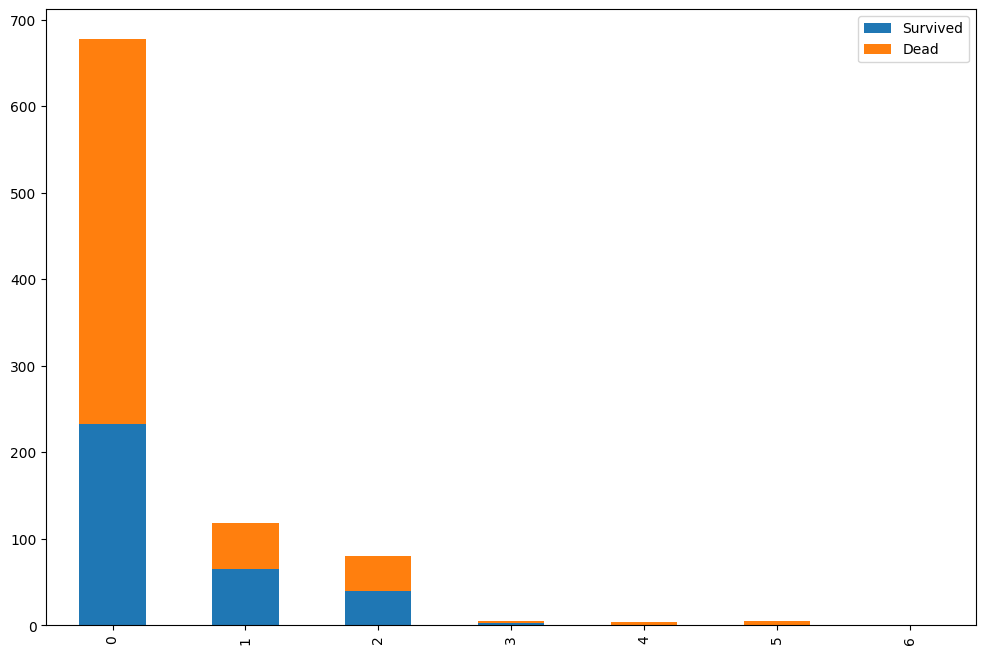

In [36]:
# 질문을 던진다. > 어떤 컬림이 생존확률에 영향을 미칠까?
bar_chart('Parch')

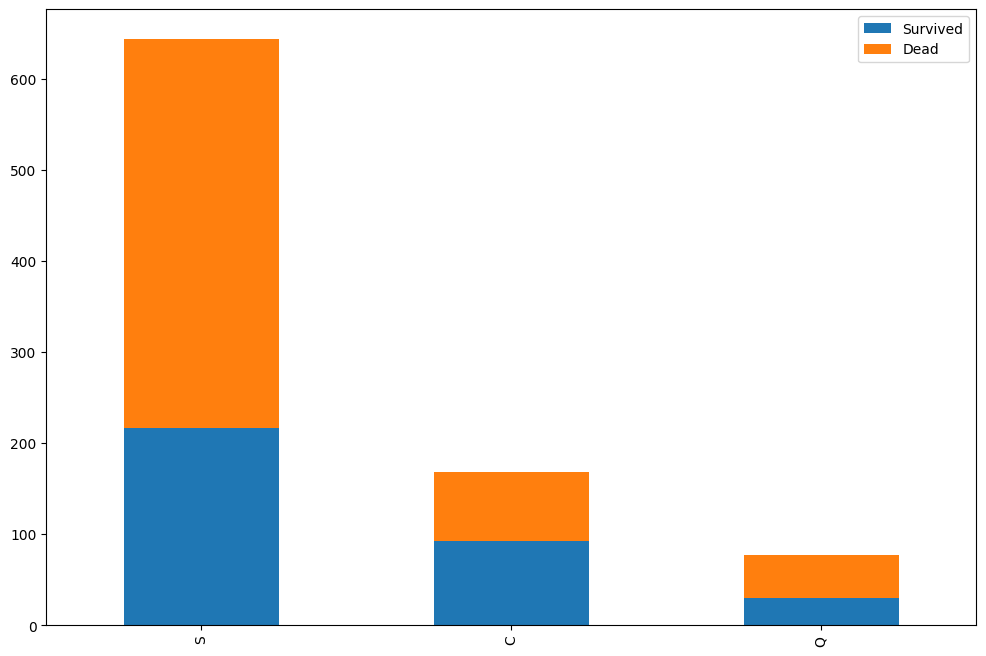

In [64]:
bar_chart('Embarked')

In [65]:
# 가장 많은 요금을 낸 상위 10명의 생존율은 어떻게 될까
df_train.sort_values(by='Fare', ascending=False).head(10)['Survived'].value_counts()
df_train.sort_values(by='Fare', ascending=False).tail(10)['Survived'].value_counts()

0    10
Name: Survived, dtype: int64

In [103]:
train_test_data = [df_train, df_test]

for data in train_test_data:
    data['Name'] = data['Name'].str.extract(' ([A-Za-z]+)\.')

In [104]:
df_train['Name']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Name, Length: 891, dtype: object

In [105]:
# 문자열 > 숫자형 제이터로 변경
name_mapping = {
    "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 4, "Rev":3
}

for data in train_test_data:
    data['Name'] = data['Name'].map(name_mapping)

In [106]:
df_train['Name'].value_counts()

0.0    517
1.0    182
2.0    125
3.0     46
4.0      7
Name: Name, dtype: int64

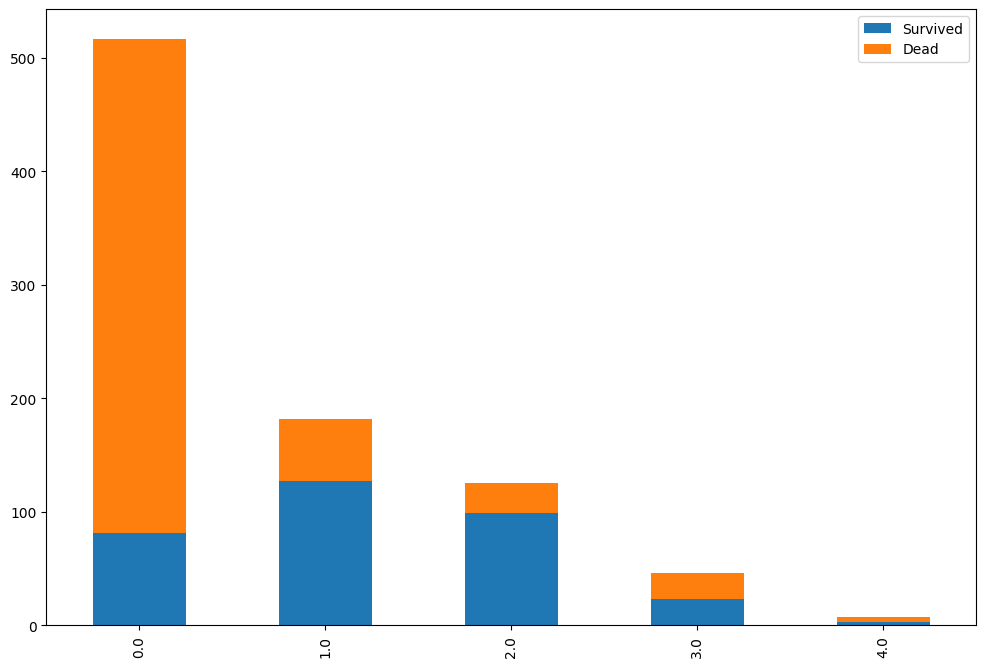

In [77]:
bar_chart("Name")

In [107]:
# Sex
df_train['Sex'] = df_train['Sex'].replace({"male":0, "female":1})
df_test['Sex'] = df_test['Sex'].replace({"male":0, "female":1})

In [108]:
df_train['Sex'].value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [110]:
# Age
df_train['Age'].isna().sum()

df_train['Age'].fillna(df_train.groupby('Name')['Age'].transform('mean'), inplace=True)
df_test['Age'].fillna(df_train.groupby('Name')['Age'].transform('mean'), inplace=True)

In [111]:
df_train['Age'].isna().sum()


0

In [112]:
import numpy as np

age_bins = [0, 16, 32, 55, 100]
age_labels = [0, 1, 2, 3]

for data in train_test_data:
    data['Age'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)


In [113]:
df_train['Age'].value_counts()

1    382
2    365
0    104
3     40
Name: Age, dtype: int64

In [117]:
# SibSp, Parch

for data in train_test_data:
    data['Family'] = data['SibSp'] + data['Parch'] + 1



In [118]:
df_train['Family'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family, dtype: int64

In [120]:
# Fare
fare_bins = [0, 20, 100, 1000]
fare_labels = [0, 1, 2]

for data in train_test_data:
    data['Fare'] = pd.cut(data['Fare'], bins=fare_bins, labels=fare_labels)

In [122]:
df_train['Fare'].value_counts()

0    500
1    323
2     53
Name: Fare, dtype: int64

In [173]:
df_train['Embarked'] = df_train['Embarked'].replace({"S":0, "C":1, "Q":2})
df_test['Embarked'] = df_test['Embarked'].replace({"S":0, "C":1, "Q":2})

In [129]:
df_test['Age'].fillna(0, inplace=True)
df_test['Age'].isna().sum()

0

In [174]:
df_train['Embarked'].value_counts()
df_train['Embarked'].fillna(0, inplace=True)
df_test['Embarked'].fillna(0, inplace=True)

df_train['Embarked'].isna().sum()


0

In [175]:
drop_train_cols = ['PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
df_train_final = df_train.drop(drop_train_cols, axis=1)


In [176]:
drop_test_cols = ['SibSp', 'Parch', 'Ticket', 'Cabin']
df_test_final = df_test.drop(drop_test_cols, axis=1)
df_test_final

,PassengerId,Pclass,Name,Sex,Age,Fare,Embarked,Family
0,892,3,0.0,0,2,0,2,1
1,893,3,2.0,1,2,0,0,2
2,894,2,0.0,0,3,0,2,1
3,895,3,0.0,0,1,0,0,1
4,896,3,2.0,1,1,0,0,3
...,...,...,...,...,...,...,...,...
413,1305,3,0.0,0,2,0,0,1
414,1306,1,NaN,1,2,2,1,1
415,1307,3,0.0,0,2,0,0,1
416,1308,3,0.0,0,2,0,0,1


In [177]:
df_train_final.fillna(0, inplace=True)
df_train_final.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
Fare        0
Embarked    0
Family      0
dtype: int64

In [178]:
df_test_final.fillna(0, inplace=True)
df_test_final.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
Fare           0
Embarked       0
Family         0
dtype: int64

In [179]:
features = df_train_final.drop('Survived', axis=1)
labels = df_train_final['Survived']

In [142]:
# 모델링
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [143]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [144]:
# KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=123)


In [161]:
dt_clf = DecisionTreeClassifier()
scores = cross_val_score(dt_clf, features, labels, cv=kfold, scoring='accuracy')
print(np.mean(scores)*100)

80.01622971285892


In [162]:
# KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, features, labels, cv=kfold, scoring='accuracy')

print(np.mean(scores)*100)

79.23345817727841


In [163]:
# RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5)
scores = cross_val_score(rf, features, labels, cv=kfold, scoring='accuracy')

print(np.mean(scores)*100)

79.12109862671659


In [165]:
# GaussianNB
gb = GaussianNB()
scores = cross_val_score(gb, features, labels, cv=kfold, scoring='accuracy')

print(np.mean(scores)*100)

80.35705368289638


In [166]:
# SVC
svc = SVC()
scores = cross_val_score(svc, features, labels, cv=kfold, scoring='accuracy')

print(np.mean(scores)*100)


83.04744069912608


In [168]:
# SVC 알고리즘을 사용해서 최종 결과값 도출

svc.fit(features, labels)

SVC()

In [ ]:
test_data_encoded = pd.get_dummies(test_data)


In [182]:
# 수능 시험 보러가기. 수능 문제?
test_data = df_test_final.drop('PassengerId', axis=1)
test_data # 수능문제

pred = svc.predict(test_data)

In [192]:
df_final_submit = pd.DataFrame({
    "PassengerId": df_test_final['PassengerId'],
    "Survived": pred
})

df_final_submit.set_index('PassengerId', inplace=True)

df_final_submit

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [193]:
df_final_submit.to_csv('submission.csv', index=False)